<a href="https://colab.research.google.com/github/coelhosilva/it213_research/blob/master/models/dnn/dnn_1_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting air transport passenger flows - a deep neural network approach

First step is to import our packages. The tensorflow version is also being displayed.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from google.colab import drive
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
print(tf.__version__)

2.3.0


## Data inputs

Grabbing data from google cloud storage.

In [ ]:
# drive.mount("/content/drive")
# matriz_od = pd.read_csv('/content/drive/MyDrive/matriz_od_aerea_br_econ.zip')
# https://drive.google.com/file/d/1bELSTBFoPt0GZ01isQDyOtXNZeMhHSCS/view?usp=sharing

file_id = '1bELSTBFoPt0GZ01isQDyOtXNZeMhHSCS'
url_download = 'https://drive.google.com/uc?export=download&id=' + file_id
matriz_od = pd.read_csv(url_download)

## Data prepping

Filtering, subsetting, adjusting.

In [ ]:
dataset = matriz_od.copy()
dataset = dataset[dataset['viagensTotais'] > 1000]
viagens_original = dataset['viagensTotais']
dataset = dataset[['viagensTotais','pop_origem', 'pop_destino', 'ppc_origem', 'ppc_destino', 'distancia']]
print(dataset.tail())

        viagensTotais  pop_origem  ...  ppc_destino     distancia
156277           1273      127686  ...     80502.47  1.635014e+06
156282           6983       19816  ...     80502.47  1.643369e+06
156288           5716      342405  ...     80502.47  1.820883e+06
156295           1831      251983  ...     80502.47  6.887146e+05
156299           4788      251627  ...     80502.47  8.098299e+05

[5 rows x 6 columns]


In [ ]:
# Dealing with empty data. Check it and drop it
print(dataset.isna().sum())

viagensTotais    0
pop_origem       0
pop_destino      0
ppc_origem       0
ppc_destino      0
distancia        0
dtype: int64


In [ ]:
# Check columns
print(dataset.columns.values)

['viagensTotais' 'pop_origem' 'pop_destino' 'ppc_origem' 'ppc_destino'
 'distancia']


In [ ]:
# # Converting numerical data to categorical and getting the dummies.
# dataset['dummy_airport_origin'] = dataset['dummy_airport_origin'].map({0: 'No airport origin', 1: 'Airport origin'})
# dataset['dummy_airport_destination'] = dataset['dummy_airport_destination'].map({0: 'No airport dest', 1: 'Airport dest'})
# dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
# print(dataset.tail())

In [ ]:
# Transformando em log
dataset = np.log(dataset)
dataset['viagensTotais'] = viagens_original

### Train test split e normalização

Separação do dataset em conjuntos de treinamento e de testes.
Plot da variável alvo e das variáveis explanatórias.
Definição do processo de normalização.



In [ ]:
# Splitting data into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

                count          mean  ...          75%           max
viagensTotais  4214.0  11940.990745  ...  4927.000000  1.574028e+06
pop_origem     4214.0     13.090625  ...    14.313693  1.632120e+01
pop_destino    4214.0     13.694587  ...    14.870640  1.632120e+01
ppc_origem     4214.0     10.426273  ...    10.854685  1.275086e+01
ppc_destino    4214.0     10.473977  ...    10.854685  1.275086e+01
distancia      4214.0     14.069772  ...    14.576703  1.515022e+01

[6 rows x 8 columns]


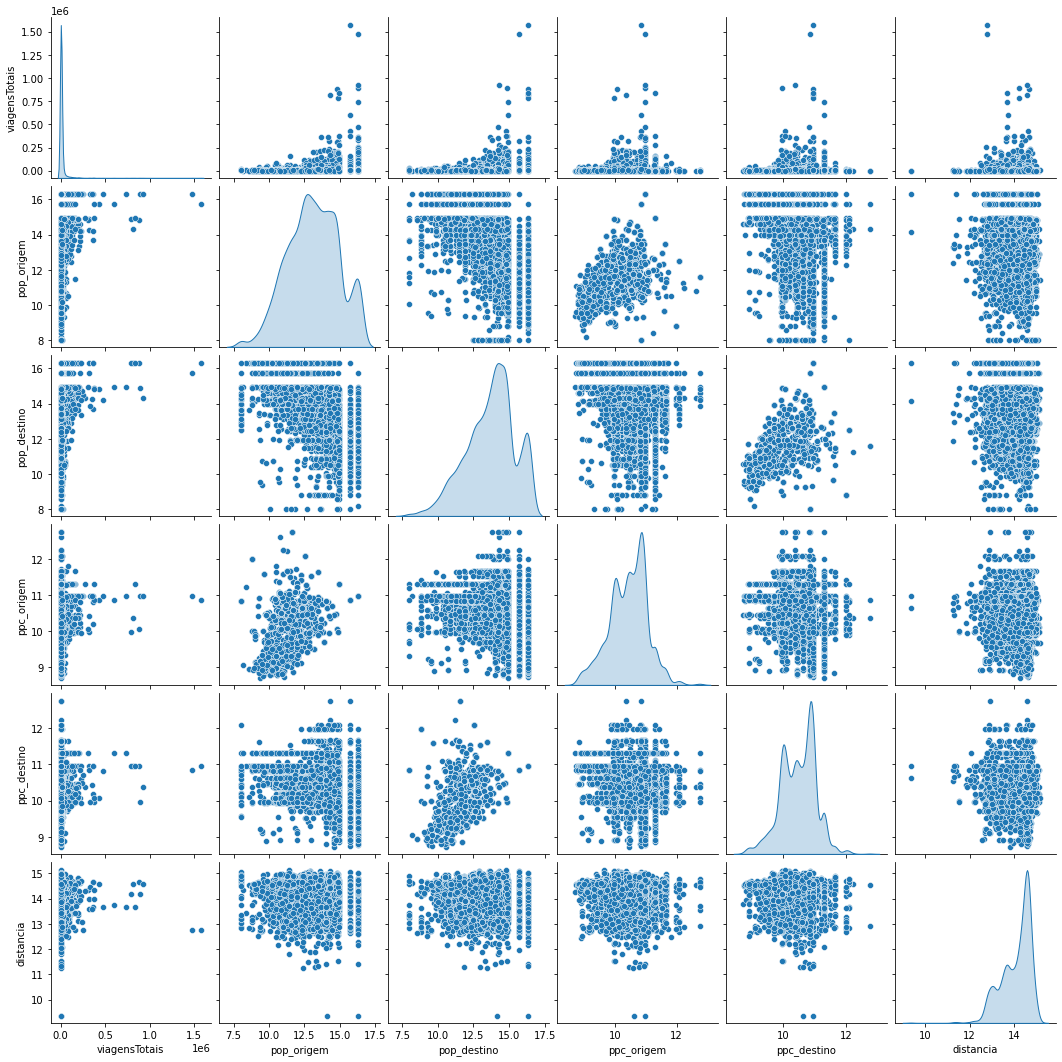

In [ ]:
# Inspecting the data
sns.pairplot(train_dataset[['viagensTotais',
 'pop_origem', 'pop_destino', 'ppc_origem', 'ppc_destino', 'distancia']], diag_kind='kde')
print(train_dataset.describe().transpose())

In [ ]:
# Splitting features from labels
X_train = train_dataset.copy()
y_train = X_train.pop('viagensTotais')

X_test = test_dataset.copy()
y_test = X_test.pop('viagensTotais')

In [ ]:
# Normalization
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

## Model

Building a deep neural network.


In [ ]:
# DNN
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_model = build_and_compile_model(normalizer)

print(dnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 33,548
Trainable params: 33,537
Non-trainable params: 11
___________________________________________________

In [ ]:
# Training the model
history = dnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=1500)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())

            loss     val_loss  epoch
1495  72850720.0  305145184.0   1495
1496  77676120.0  357094912.0   1496
1497  93290280.0  351208576.0   1497
1498  85680096.0  322614944.0   1498
1499  81211232.0  309760576.0   1499


## Assessment
Evaluating training history.

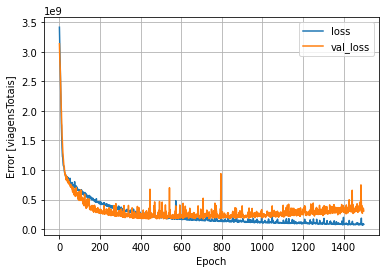

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [viagensTotais]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

Evaluating model performance on test dataset.

In [ ]:
# Retrieving model performance based on its criteria
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=0)
print(test_results)

{'dnn_model': 388428736.0}


In [ ]:
# Predicting
# Train dataset
y_train_np = np.array(y_train)
y_train_pred = np.round(np.array(dnn_model.predict(X_train)).flatten(), 0)

# Test dataset
y_test_np = np.array(y_test)
y_test_pred = np.round(np.array(dnn_model.predict(X_test)).flatten(), 0)

# Error metrics
rmse_train = (mean_squared_error(y_train_np, y_train_pred))**(1/2)
mae_train = mean_absolute_error(y_train_np, y_train_pred)

rmse_test = (mean_squared_error(y_test_np, y_test_pred))**(1/2)
mae_test = mean_absolute_error(y_test_np, y_test_pred)

# Printing
print("Root mean squared error - training set: {}".format(rmse_train))
print("Mean absolute error - training set: {}".format(mae_train))
print("Root mean squared error - test set: {}".format(rmse_test))
print("Mean absolute error - test set: {}".format(mae_test))

Root mean squared error - training set: 11054.782293040042
Mean absolute error - training set: 4647.205742762221
Root mean squared error - test set: 19708.590571571494
Mean absolute error - test set: 7148.441176470588


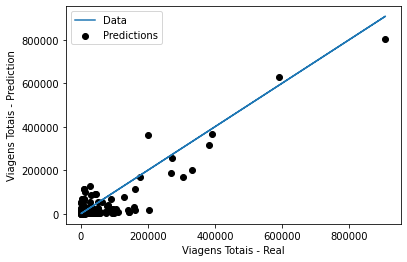

In [ ]:
def plot_predictions(x, y, lim=None):
  plt.plot(x, x, label='Data')
  plt.scatter(x, y, color='k', label='Predictions')
  if lim is not None:
    plt.xlim(lim)
    plt.ylim(lim)
  plt.xlabel('Viagens Totais - Real')
  plt.ylabel('Viagens Totais - Prediction')
  plt.legend()

# plot_predictions(real,y_pred, lim=[1000, 10000])
plot_predictions(y_test_np, y_test_pred)



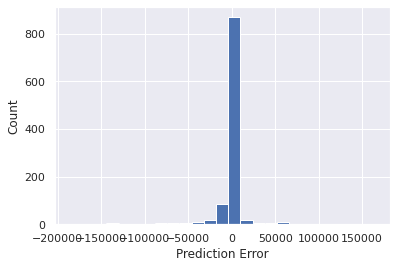

In [ ]:
# Error distribution
error = y_test_pred - y_test_np
error_df = pd.DataFrame({"error_actual": error, "y_test_pred": y_test_pred, "y_test": y_test_np})

plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

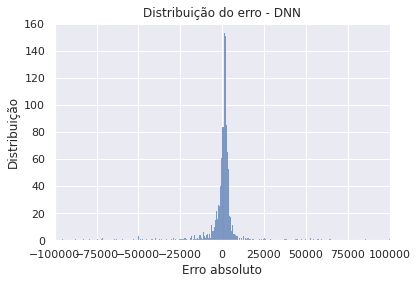

In [ ]:
sns.set()

fig, ax = plt.subplots()
sns.histplot(error, ax=ax)
_ = ax.set(
    xlabel="Erro absoluto",
    ylabel="Distribuição", xlim=(-100000, 100000),
    title="Distribuição do erro - DNN"
    )


In [ ]:
# Exporting data
hist.to_csv('dnn_history.csv', index=False)
error_df.to_csv('dnn_error.csv', index=False)